In [1]:
from config import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import re
import random

import librosa
import datasets
from datasets import Audio

import transformers
from transformers import WhisperProcessor, WhisperForConditionalGeneration, TrainingArguments, Trainer, AutoTokenizer, AutoModel, WhisperForAudioClassification, default_data_collator, AutoModelForSequenceClassification
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from transformers import HubertForCTC, Wav2Vec2Processor
import evaluate 
from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings("ignore")

## 1. DatasetLoading and Pre-Processing Dataset

In [2]:
minds_14 = datasets.load_dataset("PolyAI/minds14","all")

In [3]:
minds_14 = minds_14.cast_column("audio", Audio(sampling_rate=16000)) # Ubah menjadi SR = 16kHz

## 2. Exploratory Data Analysis 

In [4]:
keys_negara = {
    0: "CZECH",
    1: "GERMAN",
    2: "ENGLISH",
    3: "ENGLISH",
    4: "ENGLISH",
    5: "SPANISH",
    6: "FRENCH",
    7: "ITALIAN",
    8: "KOREAN",
    9: "DUTCH",
    10: "POLISH",
    11: "PORTUGUESE",
    12: "RUSSIAN",
    13: "CHINESE"
}
keys_intent = {
    0: 'abroad',
    1: 'address',
    2: 'app_error',
    3: 'atm_limit',
    4: 'balance',
    5: 'business_loan',
    6: 'card_block',
    7: 'cash_deposit',
    8: 'direct_debit',
    9: 'freeze',
    10: 'high_value_payment',
    11: 'joint_account',
    12: 'latest_transactions',
    13: 'pay_bill'
}

In [5]:
lang_ids = minds_14["train"]["lang_id"][:]
lang_ids = pd.Series(lang_ids)
lang_ids = lang_ids.map(lambda x : keys_negara[x])

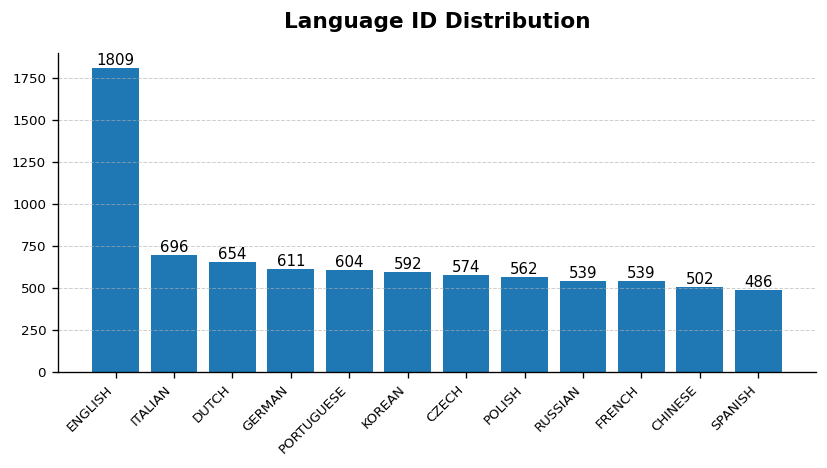

In [6]:
counts = lang_ids.value_counts()

# Setup figure
plt.figure(figsize=(7, 4), dpi=120)

# Bar plot
bars = plt.bar(
    counts.index.astype(str),
    counts.values
)

# Judul & label (professional style)
plt.title(
    "Language ID Distribution",
    fontsize=13,
    fontweight="bold",
    pad=15
)

# Grid halus
plt.grid(
    axis="y",
    linestyle="--",
    linewidth=0.6,
    alpha=0.6
)

# Hilangkan border atas & kanan
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Rotasi label x agar rapi
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)

# Tambahkan nilai di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom",
        fontsize=9
    )

# Layout rapi
plt.tight_layout()

plt.show()

In [7]:
intent_ids = minds_14["train"]["intent_class"][:]
intent_ids = pd.Series(intent_ids)
intent_ids = intent_ids.map(lambda x : keys_intent[x])

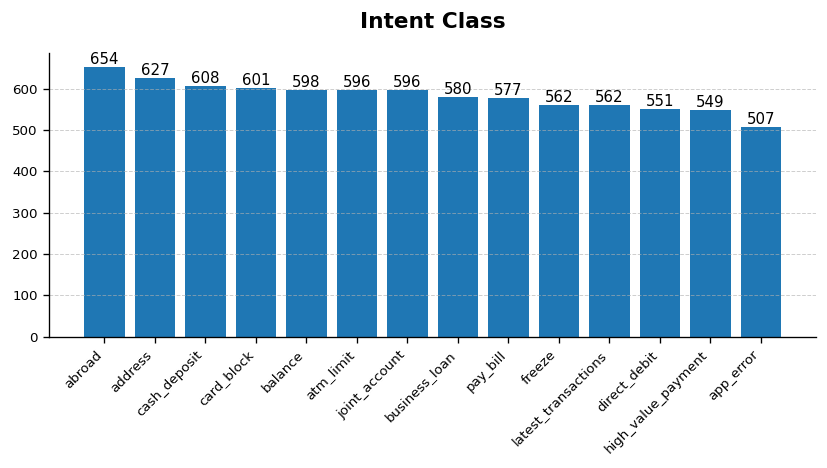

In [8]:
counts = intent_ids.value_counts()

# Setup figure
plt.figure(figsize=(7, 4), dpi=120)

# Bar plot
bars = plt.bar(
    counts.index.astype(str),
    counts.values
)

# Judul & label (professional style)
plt.title(
    "Intent Class",
    fontsize=13,
    fontweight="bold",
    pad=15
)

# Grid halus
plt.grid(
    axis="y",
    linestyle="--",
    linewidth=0.6,
    alpha=0.6
)

# Hilangkan border atas & kanan
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Rotasi label x agar rapi
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)

# Tambahkan nilai di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom",
        fontsize=9
    )

# Layout rapi
plt.tight_layout()

plt.show()

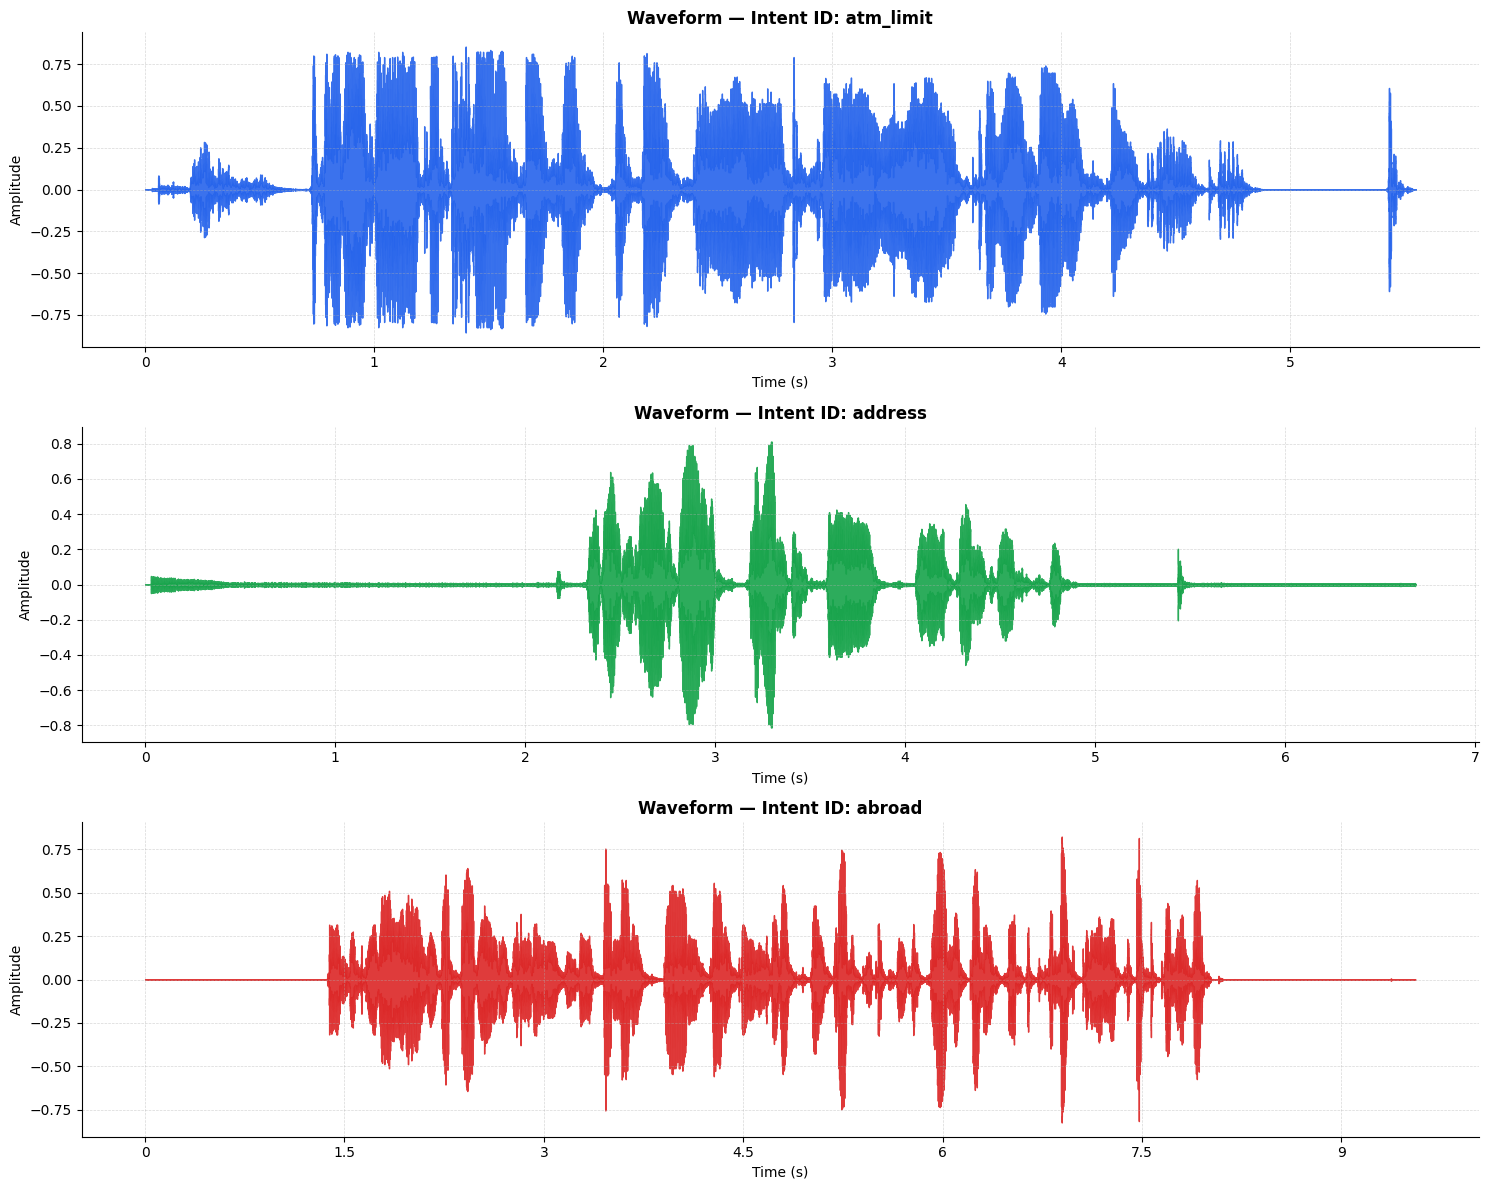

In [9]:
## First we want to see the first dataset waveform : 
plt.figure(figsize = (15,12))
no_duplicate = intent_ids.drop_duplicates(keep = "first")
index_shown = no_duplicate.index[:3]
colors = ["#2563eb", "#16a34a", "#dc2626"]  # blue, green, red

for i in range(3):
    plt.subplot(3, 1, i + 1)

    audio, sr, label, translate = get_feature(minds_14["train"], index_shown[i])

    librosa.display.waveshow(
        audio,
        sr=sr,
        color=colors[i],
        alpha=0.9
    )

    plt.title(
        f"Waveform — Intent ID: {no_duplicate.iloc[i]}",
        fontsize=12,
        fontweight="bold"
    )

    plt.xlabel("Time (s)", fontsize=10)
    plt.ylabel("Amplitude", fontsize=10)

    # Grid halus (paper-style)
    plt.grid(
        linestyle="--",
        linewidth=0.5,
        alpha=0.5
    )

    # Clean spines
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

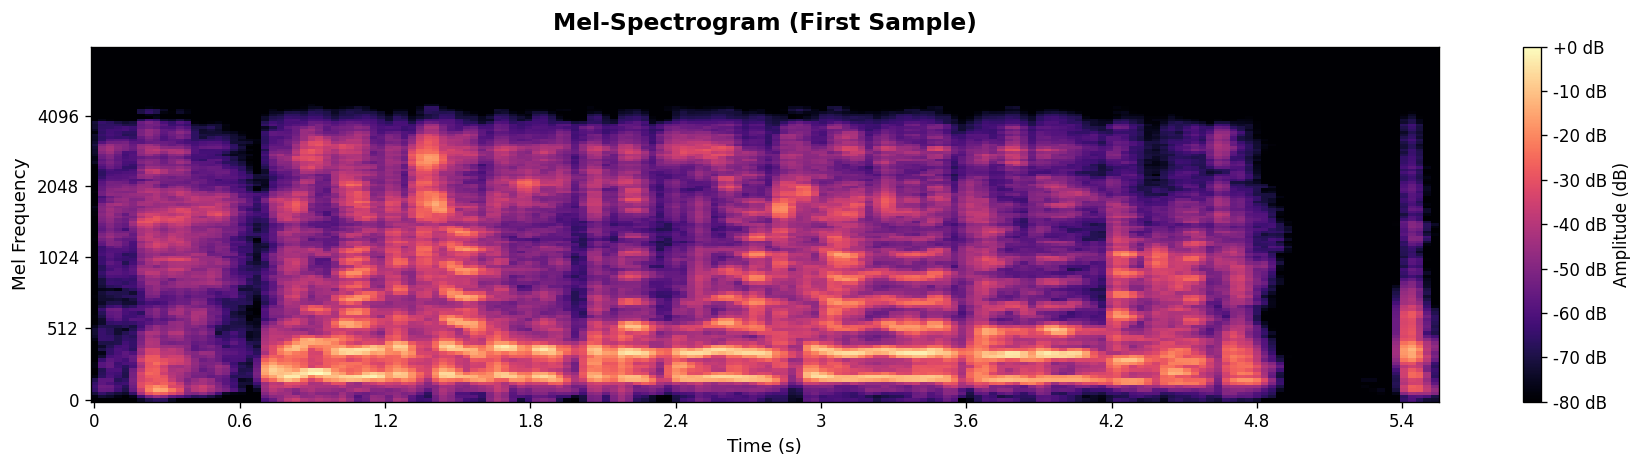

In [10]:
# Load first sample
audio, sr, label, translate = get_feature(minds_14["train"], 0)

# Mel-spectrogram (power → dB)
S = librosa.feature.melspectrogram(
    y=audio,
    sr=sr,
    n_mels=128,
    fmax=sr // 2
)
S_db = librosa.power_to_db(S, ref=np.max)

# Plot
plt.figure(figsize=(15, 4), dpi=120)

librosa.display.specshow(
    S_db,
    sr=sr,
    x_axis="time",
    y_axis="mel",
    cmap="magma"
)

plt.title(
    "Mel-Spectrogram (First Sample)",
    fontsize=14,
    fontweight="bold",
    pad=10
)

plt.xlabel("Time (s)", fontsize=11)
plt.ylabel("Mel Frequency", fontsize=11)

# Colorbar (essential for spectrograms)
cbar = plt.colorbar(format="%+2.0f dB")
cbar.set_label("Amplitude (dB)", fontsize=10)

plt.tight_layout()
plt.show()

## 4. Data Splitting and Training

In [11]:
minds_14_splitted = minds_14["train"].train_test_split(test_size = 0.2, stratify_by_column="lang_id")

In [12]:
temporary_pandas = minds_14["train"].to_pandas()
english = temporary_pandas.loc[temporary_pandas["lang_id"].isin([2,3,4])]
english = minds_14["train"].select(list(english.index))

temporary_pandas = minds_14["train"].to_pandas()
not_english = temporary_pandas.loc[~ temporary_pandas["lang_id"].isin([2,3,4])]
not_english = minds_14["train"].select(list(not_english.index))

english = english.train_test_split(test_size = 0.2)
not_english = not_english.train_test_split(test_size = 0.2)

## 5. Data Modelling [WHISPERS] => Before Fine Tune

In [ ]:
processor = WhisperProcessor.from_pretrained("openai/whisper-large-v3")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large-v3")
wer_calculation = evaluate.load("wer")
model_sent_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model_sent_core = AutoModel.from_pretrained("bert-base-uncased")

In [13]:
def get_embeds(sentence : str) : 
    input_ids = model_sent_tokenizer(sentence, return_tensors = "pt")
    with torch.no_grad() : 
        hasil = model_sent_core(**input_ids).last_hidden_state
    return hasil.mean(axis = 1)

def func(x) : 
    audio = [a["array"] for a in x["audio"]]
    sr = 16000
    label = x["transcription"]
    
    tokenized_result = processor(audio, sampling_rate = sr, return_tensors = "pt")
    with torch.no_grad() : 
        hasil = model.generate(**tokenized_result)
    hasil = processor.batch_decode(hasil, skip_special_tokens = True)

    score_list = []
    hasil_list = []
    label_list = []
    for h,l in zip(hasil,label) : 
        h = cleaning_text(h)
        l = cleaning_text(l)
        hasil_list.append(h)
        label_list.append(l)
        score = wer_calculation.compute(predictions=[h], references = [l])
        score_list.append(score)
    return {"Prediction":hasil_list, "Label":label_list, "Score" : score_list}

In [ ]:
index_shuffled = list(range(362))

random.seed(42)
random.shuffle(index_shuffled)

predictions = []
references = [] 
wer_score = []

test_english = english["test"].select(index_shuffled[:100])
dataset_result = test_english.map(func, batched = True, batch_size = 32)
pd.DataFrame({"Prediction" : dataset_result["Prediction"], "Label" : dataset_result["Label"], "Score" : dataset_result["Score"]})

In [ ]:
RESULT_WER = float(np.mean(np.array(dataset_result["Score"][:])))
print(f"Result WER English Before Fine Tuning : {RESULT_WER}")

cosine_similarity_list = []

for p,l in zip(dataset_result["Prediction"], dataset_result["Label"]) : 
    p_embeed = get_embeds(p)
    l_embeed = get_embeds(l)
    cosine_similarity_list.append(F.cosine_similarity(p_embeed, l_embeed).item())
dataset_result = dataset_result.add_column("Cosine Similarity",cosine_similarity_list)
df = pd.DataFrame({"Prediction" : dataset_result["Prediction"], "Label" : dataset_result["Label"], "Score" : dataset_result["Score"], "Cosine Similarity":dataset_result["Cosine Similarity"]})
print(f"Result Cosine Similarity English Before Fine Tuning : {float(df['Cosine Similarity'].mean())}")

df.to_csv("English_Whisper.csv")

In [ ]:
## ===========================================================================================================================================================
## ===========================================================================================================================================================
## ===========================================================================================================================================================

In [ ]:
index_shuffled = list(range(1272))

random.seed(42)
random.shuffle(index_shuffled)

predictions = []
references = []
wer_score = []

test_not_english = not_english["test"].select(index_shuffled[:100])
dataset_result_2 = test_not_english.map(func, batched = True, batch_size = 16)
pd.DataFrame({"Prediction" : dataset_result_2["Prediction"], "Label" : dataset_result_2["Label"], "Score" : dataset_result_2["Score"]})

In [ ]:
RESULT_WER_2 = float(np.mean(np.array(dataset_result_2["Score"][:])))
print(f"Result WER Not English Before Fine Tuning : {RESULT_WER_2}")

cosine_similarity_list = []

for p,l in zip(dataset_result_2["Prediction"], dataset_result_2["Label"]) : 
    p_embeed = get_embeds(p)
    l_embeed = get_embeds(l)
    cosine_similarity_list.append(F.cosine_similarity(p_embeed, l_embeed).item())
dataset_result_2 = dataset_result_2.add_column("Cosine Similarity",cosine_similarity_list)
df = pd.DataFrame({"Prediction" : dataset_result_2["Prediction"], "Label" : dataset_result_2["Label"], "Score" : dataset_result_2["Score"], "Cosine Similarity":dataset_result_2["Cosine Similarity"]})
print(f"Result Cosine Similarity Not English Before Fine Tuning : {float(df['Cosine Similarity'].mean())}")

df.to_csv("NonEnglish_Whisper.csv")

In [ ]:
## ===========================================================================================================================================================
## ===========================================================================================================================================================
## ===========================================================================================================================================================

In [ ]:
index_shuffled = list(range(1634))

random.seed(42)
random.shuffle(index_shuffled)

predictions = []
references = []
wer_score = []

minds_14_splitted_test = minds_14_splitted["test"].select(index_shuffled[:100])
minds_14_splitted_test_result = minds_14_splitted_test.map(func, batched = True, batch_size = 42)
pd.DataFrame({"Prediction" : minds_14_splitted_test_result["Prediction"], "Label" : minds_14_splitted_test_result["Label"], "Score" : minds_14_splitted_test_result["Score"]})

In [ ]:
RESULT_WER_3 = float(np.mean(np.array(minds_14_splitted_test_result["Score"][:])))
print(f"Result WER Before Fine Tuning : {RESULT_WER_3}")

cosine_similarity_list = []

for p,l in zip(minds_14_splitted_test_result["Prediction"], minds_14_splitted_test_result["Label"]) : 
    p_embeed = get_embeds(p)
    l_embeed = get_embeds(l)
    cosine_similarity_list.append(F.cosine_similarity(p_embeed, l_embeed).item())
minds_14_splitted_test_result = minds_14_splitted_test_result.add_column("Cosine Similarity",cosine_similarity_list)
df = pd.DataFrame({"Prediction" : minds_14_splitted_test_result["Prediction"], "Label" : minds_14_splitted_test_result["Label"], "Score" : minds_14_splitted_test_result["Score"], "Cosine Similarity":minds_14_splitted_test_result["Cosine Similarity"]})
print(f"Result Cosine Similarity Before Fine Tuning : {float(df['Cosine Similarity'].mean())}")

df.to_csv("Overall_Whisper.csv")

In [ ]:
result_whisper = pd.DataFrame({"Dataset" : ["English","Non-English","Overall"], "WER" : [0.18,0.36,0.41], "Cosine Similarity" : [0.95,0.98,0.96]})
result_whisper # USE THE WHISPER MODEL

## 6. Data Modelling [Wav2Vec] => Before Fine Tune 

In [22]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-100h", force_download=True)
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-100h", force_download=True, use_safetensors=False)
wer_calculation = evaluate.load("wer")
model_sent_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model_sent_core = AutoModel.from_pretrained("bert-base-uncased")

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/358 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base-100h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.mask_time_emb_vector']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

In [23]:
def get_embeds(sentence : str) : 
    input_ids = model_sent_tokenizer(sentence, return_tensors = "pt")
    with torch.no_grad() : 
        hasil = model_sent_core(**input_ids).last_hidden_state
    return hasil.mean(axis = 1)

def func(x) : 
    audio = [a["array"] for a in x["audio"]]
    sr = 16000
    label = x["transcription"]
    tokenized_result = processor(audio, sampling_rate = sr, return_tensors = "pt", padding = True)
    with torch.no_grad() : 
        logits = model(**tokenized_result).logits
    hasil = torch.argmax(logits, axis = -1)
    hasil = processor.batch_decode(hasil, skip_special_tokens = True)

    score_list = []
    hasil_list = []
    label_list = []
    for h,l in zip(hasil,label) : 
        h = cleaning_text(h)
        l = cleaning_text(l)
        hasil_list.append(h)
        label_list.append(l)
        score = wer_calculation.compute(predictions=[h], references = [l])
        score_list.append(score)
    return {"Prediction":hasil_list, "Label":label_list, "Score" : score_list}

In [ ]:
index_shuffled = list(range(362))

random.seed(42)
random.shuffle(index_shuffled)

predictions = []
references = [] 
wer_score = []

test_english = english["test"].select(index_shuffled[:100])
dataset_result = test_english.map(func, batched = True, batch_size = 32)
pd.DataFrame({"Prediction" : dataset_result["Prediction"], "Label" : dataset_result["Label"], "Score" : dataset_result["Score"]})

In [ ]:
RESULT_WER = float(np.mean(np.array(dataset_result["Score"][:])))
print(f"Result WER English Before Fine Tuning : {RESULT_WER}")

cosine_similarity_list = []

for p,l in zip(dataset_result["Prediction"], dataset_result["Label"]) : 
    p_embeed = get_embeds(p)
    l_embeed = get_embeds(l)
    cosine_similarity_list.append(F.cosine_similarity(p_embeed, l_embeed).item())
dataset_result = dataset_result.add_column("Cosine Similarity",cosine_similarity_list)
df = pd.DataFrame({"Prediction" : dataset_result["Prediction"], "Label" : dataset_result["Label"], "Score" : dataset_result["Score"], "Cosine Similarity":dataset_result["Cosine Similarity"]})
print(f"Result Cosine Similarity English Before Fine Tuning : {float(df['Cosine Similarity'].mean())}")

df.to_csv("English_Wav2Vec.csv")